**M909 : Deep Learning for NLP |
Winter Semester 2023/24 |
Student ID: lt12200010 |
Student Name: Kleopatra Karapanagiotou**

**Assignments 2, 3, 4 : Code and Report**


**SENTIMENT ANALYSIS OF THE IMDB DATASET**

The IMDB Dataset consists of 50K movie reviews. The aim of these assignments is to apply different neural network architectures for classifying whether a review is positive or negative.

Neural network architectures used in this project:
*   Assignment_2:Recurrent Neural Network with LSTM cells
*   Assignment_3:Convolutional Neural Network
*   Assignment_4:Finetune a pre-trained model from Hugging Face (DistilBert)

The RNN and CNN models were trained 2 times each:
*   one with the embedding layer frozen during training
*   one using the 100-dimensional pre-trained Glove embeddings

For hyperparameter tuning the Optuna optimzation framework is usedand the following hyperparameters were optimized:


This project consists of 8 parts:
* Load the data
* Preprocess the data and split
* Build the vocabulary
* Hyperparameter tuning for the LSTM and CNN model architectures
* Training and evaluation of models without Glove pre-trained embeddings (frozen embeddings)
* Training and evaluation of models with Glove pre-trained embeddings
* Use a model from Hugging Face and fine tune it on the IMDB dataset
* Presenting the results from the models and comment on the findings

**DOWNLOAD AND IMPORT NECESSARY PACKAGES AND LIBRARIES**

In [ ]:
!pip install transformers torchtext==0.6.0
!pip install accelerate -U
!pip install optuna

In [ ]:
import torch
from torchtext import data, datasets
import random
import re
import spacy
import time
import matplotlib.pyplot as plt
import pandas as pd
import math
import numpy as np
import nltk
import numpy as np
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import collections
from sklearn.utils import resample
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report
from torch.utils.data import TensorDataset
from torchtext.data import Field, TabularDataset, BucketIterator, Iterator
import torch.nn as nn
import torchtext
import torch.nn.functional as F
import torch.optim as optim
import os
from sklearn.model_selection import train_test_split
from transformers import EarlyStoppingCallback
from transformers import DistilBertTokenizerFast
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments
import optuna

In [ ]:
# Download necessary packages and datasets
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words_set = set(stopwords.words('english'))

# Download IMDB dataset
URL = 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
!wget -P 'Data/' $URL
!tar xvzf 'Data/aclImdb_v1.tar.gz' -C 'Data/'

# Download and unzip Glove pre-trained vectors
FILE = 'GLOVE'
URL = 'http://nlp.stanford.edu/data/glove.6B.zip'
!wget -P $FILE $URL
!unzip $FILE/glove*.zip -d $FILE

**SET UP GPU FOR TRAINING**

In [ ]:
# Set up GPU for Training
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device('cpu')

**FUNCTIONS USED**

In [ ]:
# A function that calculates the time needed for training and evaluation in each epoch
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
# A function that reads a set of files in a given directory and saves the lines to a list
def load_data(path, file_list, dataset, encoding='utf8'):
    for file in file_list:
        with open(os.path.join(path, file), 'r', encoding=encoding) as text:
            dataset.append(text.read())

In [ ]:
# A function that opens, reads a file in csv with utf-8 encoding, gets the values, checks and fills empty values and checks for duplicates
def read_explore_dataframe(dataframe):

  # Count the number of examples in each class
  print(dataframe.label.value_counts())
  print()

  # Get the keys and their corresponding number of values
  keys = dataframe.keys()
  for key in keys:
    df_len = len(dataframe[key].unique()) # the length of the unique values of each column
    print('{0:25}{1:10}'.format(key,df_len))

  dataframe.dropna(inplace=True) # remove missing values and keep the dataFrame with valid entries in the same variable
  dataframe.reset_index(inplace=True,drop=True)

  dataframe.duplicated() # check for duplicates
  #print('Number of duplicates in the dataframe:', dataframe.duplicated().sum())
  print('Dataframe checked for NaN values and duplicates!')

  return dataframe

In [ ]:
# A function that takes as parameter a text and applies preprocessing steps to clean it
def text_preprocessing(text):

  # Remove tags
  TAG_RE = re.compile(r'<[^>]+>')
  no_tags = TAG_RE.sub('',text)
  # Remove unusual characters
  text = re.sub('<[^>]*>', '', no_tags)
  # Remove urls
  text = re.sub(r'http\S+','', text)
  # Remove emoticons
  emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
  # Remove punctuation
  no_punct = [word for word in emoticons if word.isalpha()]
  # Convert all words to lowercase
  text = re.sub('[\W]+', ' ', text.lower()) + " ".join(no_punct).replace('-', '')
  # Remove numbers
  no_numbers_txt = re.sub(r'\d+', '', text)
  # Tokenize
  tokens = nltk.word_tokenize(no_numbers_txt)
  # Filter out stopwords
  no_stopwords = [word for word in tokens if word not in stop_words_set]
  # Lemmatize
  lemmatizer = WordNetLemmatizer()
  lemmas = " ".join([lemmatizer.lemmatize(token) for token in no_stopwords])

  return lemmas

In [ ]:
# A function that gets as input the dataframe and gets the necessary values from the columns after resampling and pre-processing
def get_columns(dataframe, feature, label):

  # Get only the columns we are interested in
  dataset = dataframe[[feature,label]]

  # Apply the pre-processing function to the dataframe containing the text (feature column)
  dataset[feature] = dataset[feature].apply(text_preprocessing)
  print('\nText done pre-processing!')

  # Divide the X and y values
  X = dataset[feature]
  y = dataset[label]

  # Split train dataset to train and validation set
  X_train, X_val, Y_train, Y_val = train_test_split(X, y, test_size = 0.20, random_state = 42)
  print('The dataset is split into training and validation sets!')

  print('Shape of x_train: ', X_train.shape)
  print('Shape of y_train: ', Y_train.shape)
  print('Shape of x_val:  ', X_val.shape)
  print('Shape of y_val:  ', Y_val.shape)

  # Concatenate the X,Y data of training and validation data
  train = pd.concat([X_train, Y_train], axis=1)
  valid = pd.concat([X_val, Y_val], axis=1)

  # Save the training and validation data into csv format
  train.to_csv("/content/train.csv", index=False)
  valid.to_csv("/content/valid.csv", index=False)

  return train, valid

In [ ]:
# A function that creates iterators for the given datasets
# In each batch, the sentences are transposed to be descending vertically
# Each index represents a token and each column represents a sentence
# The batch size specifies the number of columns
# The lambda function finds sentences of the same length,
#which is beneficial for efficient processing, especially in the context of LSTM models where sequences need to be of the same length.The sorting helps in padding sequences to similar lengths

def create_iterators(train_dataset, validation_dataset, test_dataset, batch_size):

  train_iterator, val_iterator, test_iterator = data.BucketIterator.splits(
  # The Datasets to load Examples from
  (train_dataset, validation_dataset, test_dataset),
  # The batch size
  batch_size = batch_size,
  # Function to use for sorting examples
  sort_key = lambda x: len(x.Review),
  # Repeat the iterator for multiple epochs
  repeat = False,
  # Shuffle data on each epoch run
  shuffle = True,
  # Use 'sort_key' to sort examples in each batch: True ensures that sentences within a batch are of similar length, optimizing for efficient processing
  sort_within_batch = True,
  device = device)

  return train_iterator, val_iterator, test_iterator

In [ ]:
# A function that calculates the trainable parameters of the model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# A function that sets seed for reproducibility
def set_seed(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

In [ ]:
# ====== METRICS CALCULATION ======

# A function that calculates accuracy per batch and returns rounded predictions
def binary_accuracy(preds, y):

    # Round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() # Convert into float for division
    acc = correct.sum() / len(correct)
    return acc


# A function that calculates all the metrics using the testing set
def calculate_metrics(y_true, preds):
  print('\nCalculating metrics...')
  # Calculate the accuracy of the model
  acc = accuracy_score(y_true, preds)
  # Calculate general precision, recall, F1 score of the model and of each class
  precision, recall, fscore, support = score(y_true, preds)
  print('Accuracy: {}'.format(acc))
  print('Precision: {}'.format(precision))
  print('Recall: {}'.format(recall))
  print('F1 score: {}'.format(fscore))
  print('Support: {}'.format(support))

  # Print classification report
  print(classification_report(y_true, preds))

In [ ]:
# ====== TRAINING (TRAINING SET) ======
def train(model, iterator, optimizer, criterion, clip):

  training_loss = 0
  training_acc = 0

  # Set model to training mode
  model.train()

  # For each batch in the training iterator
  for batch in tqdm(iterator):

    # Zero the gradients
    optimizer.zero_grad()

    # Compute the predictions
    predictions = model(batch.Review).squeeze(1)

    # Compute the loss
    loss = criterion(predictions, batch.Label)

    # Compute the accuracy
    acc = binary_accuracy(predictions, batch.Label.float())

    # Use loss to compute gradients
    loss.backward()

    # Clip the gradient value
    nn.utils.clip_grad_norm_(model.parameters(), clip)

    # Use optimizer to take gradient step
    optimizer.step()

    training_loss += loss.item()
    training_acc += acc.item()

  loss_of_epoch = training_loss / len(iterator)
  accuracy_of_epoch = training_acc / len(iterator)

  # Return the loss and accuracy, averaged across each epoch
  # len of iterator = number of batches in the iterator
  return loss_of_epoch, accuracy_of_epoch

In [ ]:
# ====== EVALUATION (VALIDATION SET) ======
def evaluate(model, iterator, criterion):

  eval_loss = 0
  eval_acc = 0

  # Set model to evaluation mode
  model.eval()

  # Don't calculate the gradients
  with torch.no_grad():

    for batch in tqdm(iterator):

      # Compute the predictions
      predictions = model(batch.Review).squeeze(1)

      # Compute the loss
      loss = criterion(predictions, batch.Label)

      # Compute the accuracy
      acc = binary_accuracy(predictions, batch.Label.float())

      eval_loss += loss.item()
      eval_acc += acc.item()

  loss_of_epoch = eval_loss / len(iterator)
  accuracy_of_epoch = eval_acc / len(iterator)

  # Return the loss and accuracy, averaged across each epoch
  # len of iterator = number of batches in the iterator
  return loss_of_epoch, accuracy_of_epoch


# ====== EVALUATION (TESTING SET) ======
def testing(model, iterator):

  predictions_all = []
  labels_all = []

  model.eval()

  with torch.no_grad():

    for batch in iterator:
      predictions = model(batch.Review).squeeze(1)
      predictions_all +=  torch.round(torch.sigmoid(predictions)).flatten().cpu().numpy().tolist()
      labels_all += batch.Label.flatten().cpu().numpy().tolist()

  return predictions_all, labels_all

**MODELS**

In [ ]:
# ====== Recurrent Neural Network Model with LSTM ======
class LSTM_Model(nn.Module):

  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, d_rate, pad_idx):

    super(LSTM_Model, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, bidirectional=True, dropout=d_rate)
    self.dense = nn.Linear(2 * hidden_dim, output_dim)
    self.dropout = nn.Dropout(d_rate)

  def forward(self, x):
    # Get the word embeddings of the batch
    # x: (sentence_length, batch_size)
    embedded = self.dropout(self.embedding(x))
    # embedded: (sentence_length, batch_size, embedding_dim)

    # Propagate the input through LSTM layer/s
    _, (hidden, _) = self.lstm(embedded)

    # Extract output of the last time step
    # Concat the final output of forward direction and backward direction
    hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
    # hidden: (batch_size, hidden_dim * 2)

    output = self.dense(hidden)

    return output

In [ ]:
# ====== Convolutional Neural Network Model ======
class CNN(nn.Module):

  def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout, pad_idx):
    super(CNN,self).__init__()
    #Embedding layer
    self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
    #Conv Network
    # in_channels: the number of "channels" in the image going into the convolutional layer
    # out_channels: the number of filters
    # the kernel_size: the size of the filters. Each of the kernel_sizes is going to be [n x emb_dim] where n is the size of the n-grams
    self.convs = nn.ModuleList([nn.Conv2d(in_channels = 1, out_channels = n_filters, kernel_size = (fs, embedding_dim)) for fs in filter_sizes])
    #Fully  connected +Dropout
    self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
    self.dropout = nn.Dropout(dropout)

  def forward(self, text):
    #input text is permuted to have the batch size as the first dimension
    text = text.permute(1, 0)
    #text is embedded, and dropout is applied
    embedded = self.dropout(self.embedding(text))
    embedded = embedded.unsqueeze(1)
    #Convolution and ReLU activation are applied to each filter size.
    conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
    #1D max pooling is performed over the width of each feature map
    pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
    #Pooled feature maps are concatenated and passed through dropout
    cat = self.dropout(torch.cat(pooled, dim = 1))
    #result is passed through the fully connected layer to get the final output
    return self.fc(cat)

**RUN THE SCRIPT - APPLY FUNCTIONS**

**PART 1: LOAD THE DATA**

In [ ]:
set_seed(42)

# Path to dataset location
path = '/content/Data/aclImdb'

# Create lists that will contain read lines
train_pos, train_neg, test_pos, test_neg = [], [], [], []

# Create a dictionary of paths and lists that store lines (key: value = path: list)
sets_dict = {'train/pos/': train_pos, 'train/neg/': train_neg,
             'test/pos/': test_pos, 'test/neg/': test_neg}

# Load the data
for dataset in sets_dict:
        file_list = [f for f in os.listdir(os.path.join(path, dataset)) if f.endswith('.txt')]
        load_data(os.path.join(path, dataset), file_list, sets_dict[dataset])

# Concatenate positive and negative into datasets, one for the training and one for the testing
train_dataset = pd.concat([pd.DataFrame({'review': train_pos, 'label':1}),
                          pd.DataFrame({'review': train_neg, 'label':0})],
                          axis=0, ignore_index=True)

test_dataset = pd.concat([pd.DataFrame({'review': test_pos, 'label':1}),
                          pd.DataFrame({'review': test_neg, 'label':0})],
                          axis=0, ignore_index=True)

In [ ]:
train_dataset.head()

,review,label
0,PRC which was the lowest of the low actually s...,1
1,"Considering it was made on a low budget, THE D...",1
2,this movie is so complex that it can be given ...,1
3,Rented and watched this short (< 90 minutes) w...,1
4,Dressed to Kill starts off with Kate Miller (A...,1


**PART 2: PREPROCESS THE DATA AND SPLIT**

In [ ]:
# ====== Prepare the datasets ======
print('------ Preparing the training and validation dataset... ------')

# Opens, reads, checks for duplicates and removes missing values
train_df = read_explore_dataframe(train_dataset)

# Gets the necessary columns, resamples, preprocesses the texts, splits into training and validation sets and saves them to csv
train_dataframe, valid_dataframe = get_columns(train_df, 'review', 'label')

------ Preparing the training and validation dataset... ------
1    12500
0    12500
Name: label, dtype: int64

review                        24904
label                             2
Dataframe checked for NaN values and duplicates!

Text done pre-processing!
The dataset is split into training and validation sets!
Shape of x_train:  (20000,)
Shape of y_train:  (20000,)
Shape of x_val:   (5000,)
Shape of y_val:   (5000,)


In [ ]:
# ====== Prepare the datasets ======
print('------ Preparing the testing dataset... ------')

# Opens, reads, checks for duplicates and removes missing values
test_df = read_explore_dataframe(test_dataset)

# Apply the function for preprocessing the text
test_df['review'] = test_df['review'].apply(text_preprocessing)
print('\nText done pre-processing!')

# Divide the text and the labels
test_texts = test_df['review']
test_labels = test_df['label']

# Concatenate the text and labels of the clean dataset into a new dataframe
test_dataframe = pd.concat([test_texts, test_labels], axis=1)

# Save the testing data into csv format
test_dataframe.to_csv("/content/test.csv", index=False)
print('The testing dataset is ready and saved into csv format!')

------ Preparing the testing dataset... ------
1    12500
0    12500
Name: label, dtype: int64

review                        24801
label                             2
Dataframe checked for NaN values and duplicates!

Text done pre-processing!
The testing dataset is ready and saved into csv format!


**PART 3: BUILD THE VOCABULARY**

In [ ]:
# ====== Load the data & Build the vocabulary ======

set_seed(42)

# Create the TEXT and LABEL fields
spacy_en = spacy.load('en_core_web_sm')
TEXT = data.Field(tokenize=lambda text: [tok.text for tok in spacy_en.tokenizer(text)], lower=True, sequential=True)
LABEL = data.LabelField(dtype = torch.float, sequential = False)

# Loading training, testing and validation data
train_data, valid_data, test_data = data.TabularDataset.splits(
    path ='/content/', train = 'train.csv',
    validation = 'valid.csv', test = 'test.csv', format = 'csv', skip_header = True,
    fields = [('Review', TEXT), ('Label', LABEL)])

print(f'Number of training examples: {len(train_data)}')
print(f'Number of valid examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

# Build the vocabulary using the train data
TEXT.build_vocab(train_data, vectors = torchtext.vocab.Vectors('/content/GLOVE/glove.6B.100d.txt'), max_size = 25000, unk_init=torch.Tensor.normal_)
LABEL.build_vocab(train_data)

print('\nTokens in TEXT vocabulary: {}'.format(len(TEXT.vocab)))
print('Tokens in LABEL vocabulary: {}'.format(len(LABEL.vocab)))

Number of training examples: 20000
Number of valid examples: 5000
Number of testing examples: 25000

Tokens in TEXT vocabulary: 25002
Tokens in LABEL vocabulary: 2


In [ ]:
print(TEXT.vocab.freqs.most_common(20))
print(TEXT.vocab.itos[:10])
print(LABEL.vocab.stoi)

[('movie', 41450), ('film', 37789), ('one', 22111), ('like', 16614), ('time', 12670), ('good', 12162), ('character', 11308), ('story', 10604), ('even', 10191), ('would', 10000), ('get', 9966), ('make', 9758), ('see', 9631), ('really', 9435), ('well', 8671), ('scene', 8493), ('much', 7778), ('people', 7545), ('bad', 7482), ('first', 7360)]
['<unk>', '<pad>', 'movie', 'film', 'one', 'like', 'time', 'good', 'character', 'story']
defaultdict(None, {'0': 0, '1': 1})


**PART 4: Hyperparameter tuning with Optuna framework**

#Defining Optuna search space for RNN_LSTM, and picking the chosen parameters as per Otuna best trial:
1. The number of layers (i.e number of stacked RNNs): 2-5 (4 was chosen)
2. Number of epochs: 5-50 (17 was chosen)
3. Hidden neurons: 10-100 (16 neurons were chosen)
4. Dropout probability : 0.2-0.7 (0.6 was chosen)
5. learing rate: 0.0001 - 0.01 (0.002 was chosen)
6. batch size: 16-128 (118 was chosen)
7. gradient clipping to avoid exploding gradients: 1-5 (4 was chosen)


In [31]:
def RNN_LSTM(TEXT, data_train, data_valid, data_test, hidden_dim, num_layers, dropout, learning_rate, num_epochs, batch_size, clip, freeze_embeddings=True):
    try:
        # Set the device
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # The number of words in the vocabulary
        input_dim = len(TEXT.vocab)
        # The dimensions of each Glove vector
        embedding_dim = 100
        # The number of output layers
        output_dim = 1
        # The Glove pre-trained embeddings
        embeddings = TEXT.vocab.vectors
        # Get pad token index from vocab
        PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

        # Instantiate the model
        model = LSTM_Model(input_dim, embedding_dim, hidden_dim, output_dim, num_layers, dropout, PAD_IDX)
        print(model)
        print(f'The model has {count_parameters(model):,} trainable parameters\n')
        model.to(device)

        # Replace the initial weights of the embedding layer with the pre-trained embeddings
        model.embedding.weight.data.copy_(embeddings)
        # Initialize <unk> and <pad> both to all zeros
        UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

        # Setting row in the embedding weights matrix to zero using the token index
        model.embedding.weight.data[UNK_IDX] = torch.zeros(embedding_dim)
        model.embedding.weight.data[PAD_IDX] = torch.zeros(embedding_dim)

        # Initialize the model parameters
        set_seed(42)

        # Create the iterators
        train_iterator, valid_iterator, test_iterator = create_iterators(data_train, data_valid, data_test, batch_size)

        # Initialize the optimizer and the loss function
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

        # Define loss function
        loss_function = nn.BCEWithLogitsLoss()
        loss_function = loss_function.to(device)

        best_valid_loss = float('inf')

        # Initialize empty lists to store the values of loss and accuracy for each epoch
        train_accuracies = []
        train_losses = []
        val_accuracies = []
        val_losses = []

        # Freeze or unfreeze the embeddings based on the parameter
        model.embedding.weight.requires_grad = not freeze_embeddings


        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_accuracy = train(model, train_iterator, optimizer, loss_function, clip)
            validation_loss, validation_accuracy = evaluate(model, valid_iterator, loss_function)

            end_time = time.time()

            epoch_mins, epoch_secs = epoch_time(start_time, end_time)

            print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s | Frozen: {freeze_embeddings}')
            print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_accuracy*100:.2f}%')
            print(f'\t Val. Loss: {validation_loss:.3f} |  Val. Acc: {validation_accuracy*100:.2f}%')

            if validation_loss < best_valid_loss:
                best_valid_loss = validation_loss
                torch.save(model.state_dict(), 'lstm_model_frozen.pt' if freeze_embeddings else 'lstm_model_unfrozen.pt')

            # Fill the empty lists with the values of accuracy and loss for training and evaluation sets
            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy)
            val_losses.append(validation_loss)
            val_accuracies.append(validation_accuracy)

        # Plot the loss vs epochs
        plt.plot(train_losses)
        plt.plot(val_losses)
        plt.title('Train vs Validation Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'])
        plt.show()

        # Plot the accuracy vs epochs
        plt.plot(train_accuracies)
        plt.plot(val_accuracies)
        plt.title('Train vs Validation Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'])
        plt.show()

        # Evaluate model on the testing set
        predictions, labels = testing(model, test_iterator)

        # Calculate the evaluation metrics on the testing set
        calculate_metrics(labels, predictions)

        # Return the last validation loss for optimization
        return {'val_loss': val_losses[-1]}

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        # Return a large value in case of an error
        return {'val_loss': float('inf')}

def lstm_objective(trial):
    # Set up the trial-specific hyperparameters
    hidden_dim = trial.suggest_int('hidden_dim', 10, 100)
    dropout = trial.suggest_float('dropout', 0.2, 0.7)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2)
    num_layers = trial.suggest_int('num_layers', 2, 5)
    num_epochs = trial.suggest_int('num_epochs', 5, 50)
    batch_size = trial.suggest_int('batch_size', 16, 128)
    clip = trial.suggest_float('clip', 0.1, 5.0)

    result = RNN_LSTM(TEXT, train_data, valid_data, test_data,
                                       hidden_dim=hidden_dim,
                                       num_layers=num_layers,
                                       dropout=dropout,
                                       learning_rate=learning_rate,
                                       num_epochs=num_epochs,
                                       batch_size=batch_size,
                                       clip=clip)

    # Return the validation loss as the objective value
    return result['val_loss']

#study = optuna.create_study(direction='minimize')
#study.optimize(lstm_objective, n_trials=50)
#best_params = study.best_params
#print("Best Hyperparameters:", best_params)
##Best Hyperparameters: {'hidden_dim': 16, 'dropout': 0.6022217632336822, 'learning_rate': 0.0025565376011509387, 'num_layers': 4, 'num_epochs': 17, 'batch_size': 118, 'clip': 4.281124290951043}


#Defining Optuna search space for CNN, and picking the chosen parameters as per Otuna best trial:
In order for the models' results to be comparable, tha same number of epochs, dropout rate,batch size, gradient clipping, learning rate were maintained like in the LSTM architecture. The only chosen hyperparameters for optuna optimization were the CNN_specific parameters, meaning: the number of filters and the filter sizes

•	Optimizer and loss function: I used the Adam optimizer with weight decay of 1e-4 and the BCEWithLogitsLoss loss function, since it was a binary classification task.

In [32]:
def CNN_EMBEDDINGS(TEXT, data_train, data_valid, data_test, num_filters, filter_sizes,dropout, learning_rate, num_epochs, batch_size, clip,freeze_embeddings=True):
    try:
        # Set the device
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # The number of words in the vocabulary
        input_dim = len(TEXT.vocab)
        # The dimensions of each Glove vector
        embedding_dim = 100
        # The number of output layers
        output_dim = 1
        # The Glove pre-trained embeddings
        embeddings = TEXT.vocab.vectors
        # Get pad token index from vocab
        PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

        model = CNN(input_dim, embedding_dim, num_filters, filter_sizes, output_dim, dropout, PAD_IDX)
        print(model)
        print(f'The model has {count_parameters(model):,} trainable parameters')
        model.to(device)

        # Replace the initial weights of the embedding layer with the pre-trained embeddings
        model.embedding.weight.data.copy_(embeddings)
        # Initialize <unk> and <pad> both to all zeros - irrelevant for sentiment analysis
        UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

        # Setting row in the embedding weights matrix to zero using the token index
        model.embedding.weight.data[UNK_IDX] = torch.zeros(embedding_dim)
        model.embedding.weight.data[PAD_IDX] = torch.zeros(embedding_dim)

        set_seed(42)

        # Create the iterators
        train_iterator, valid_iterator, test_iterator = create_iterators(data_train, data_valid, data_test, batch_size)

        # Initialize the optimizer and the loss function
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

        # Define loss function
        loss_function = nn.BCEWithLogitsLoss()
        loss_function = loss_function.to(device)

        best_valid_loss = float('inf')

        # Initialize empty lists to store the values of loss and accuracy for each epoch
        train_accuracies = []
        train_losses = []
        val_accuracies = []
        val_losses = []

        # Freeze or unfreeze the embeddings based on the parameter
        model.embedding.weight.requires_grad = not freeze_embeddings

        for epoch in range(num_epochs):

            start_time = time.time()

            train_loss, train_accuracy = train(model, train_iterator, optimizer, loss_function, clip)
            validation_loss, validation_accuracy = evaluate(model, valid_iterator, loss_function)

            end_time = time.time()

            epoch_mins, epoch_secs = epoch_time(start_time, end_time)

            print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s | Frozen: {not freeze_embeddings}')
            print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_accuracy*100:.2f}%')
            print(f'\t Val. Loss: {validation_loss:.3f} |  Val. Acc: {validation_accuracy*100:.2f}%')

            if validation_loss < best_valid_loss:
                best_valid_loss = validation_loss
                torch.save(model.state_dict(), f'cnn_model{"_frozen" if not freeze_embeddings else "_unfrozen"}.pt')

            # Fill the empty lists with the values of accuracy and loss for training and evaluation sets
            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy)
            val_losses.append(validation_loss)
            val_accuracies.append(validation_accuracy)

        # Plot the loss vs epochs
        plt.plot(train_losses)
        plt.plot(val_losses)
        plt.title('Train vs Validation Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'])
        plt.show()

        # Plot the accuracy vs epochs
        plt.plot(train_accuracies)
        plt.plot(val_accuracies)
        plt.title('Train vs Validation Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'])
        plt.show()

        # Evaluate model on the testing set
        predictions, labels = testing(model, test_iterator)

        # Calculate the evaluation metrics on the testing set
        calculate_metrics(labels, predictions)

        # Return the last validation loss for optimization
        return {'val_loss': val_losses[-1]}

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        # Return a large value in case of an error
        return {'val_loss': float('inf')}

def cnn_objective(trial):

    num_filters = trial.suggest_int('num_filters', 10, 50)
    filter_sizes = [trial.suggest_int(f'filter_size_{i}', 3, 7) for i in range(3)]
    result = CNN_EMBEDDINGS(TEXT, train_data, valid_data, test_data,
                                   num_filters=num_filters,
                                   filter_sizes=filter_sizes,
                                   dropout=0.6,
                                   learning_rate=0.002,
                                   num_epochs=17,
                                   batch_size=118,
                                   clip=4
                            )
    # Return the validation loss as the objective value
    return result['val_loss']

# Create a study object and optimize hyperparameters
#study = optuna.create_study(direction='minimize')
#study.optimize(cnn_objective, n_trials=50)

# Get the best hyperparameters
#best_params = study.best_params
#print("Best Hyperparameters:", best_params)
##Best hyperparameters: {'num_filters': 20, 'filter_size_0': 3, 'filter_size_1': 4, 'filter_size_2': 5}

**PART 5: TRAINING AND EVALUATION OF MODELS WITHOUT GLOVE PRE-TRAINED EMBEDDINGS (FROZEN EMBEDDINGS)**

LSTM_Model(
  (embedding): Embedding(25002, 100, padding_idx=1)
  (lstm): LSTM(100, 16, num_layers=4, dropout=0.6, bidirectional=True)
  (dense): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.6, inplace=False)
)
The model has 2,534,537 trainable parameters



100%|██████████| 43/43 [00:00<00:00, 134.95it/s]


Epoch: 01 | Epoch Time: 0m 3s | Frozen: True
	Train Loss: 0.658 | Train Acc: 58.20%
	 Val. Loss: 0.558 |  Val. Acc: 73.91%


100%|██████████| 43/43 [00:00<00:00, 166.56it/s]


Epoch: 02 | Epoch Time: 0m 2s | Frozen: True
	Train Loss: 0.582 | Train Acc: 70.73%
	 Val. Loss: 0.489 |  Val. Acc: 78.30%


100%|██████████| 43/43 [00:00<00:00, 162.44it/s]


Epoch: 03 | Epoch Time: 0m 2s | Frozen: True
	Train Loss: 0.544 | Train Acc: 73.62%
	 Val. Loss: 0.447 |  Val. Acc: 80.81%


100%|██████████| 43/43 [00:00<00:00, 164.07it/s]


Epoch: 04 | Epoch Time: 0m 2s | Frozen: True
	Train Loss: 0.512 | Train Acc: 75.94%
	 Val. Loss: 0.425 |  Val. Acc: 82.39%


100%|██████████| 43/43 [00:00<00:00, 169.60it/s]


Epoch: 05 | Epoch Time: 0m 2s | Frozen: True
	Train Loss: 0.488 | Train Acc: 77.24%
	 Val. Loss: 0.410 |  Val. Acc: 83.06%


100%|██████████| 43/43 [00:00<00:00, 106.71it/s]


Epoch: 06 | Epoch Time: 0m 2s | Frozen: True
	Train Loss: 0.478 | Train Acc: 77.81%
	 Val. Loss: 0.465 |  Val. Acc: 79.02%


100%|██████████| 43/43 [00:00<00:00, 164.88it/s]


Epoch: 07 | Epoch Time: 0m 2s | Frozen: True
	Train Loss: 0.470 | Train Acc: 78.41%
	 Val. Loss: 0.385 |  Val. Acc: 83.88%


100%|██████████| 43/43 [00:00<00:00, 154.88it/s]


Epoch: 08 | Epoch Time: 0m 2s | Frozen: True
	Train Loss: 0.471 | Train Acc: 78.74%
	 Val. Loss: 0.480 |  Val. Acc: 77.63%


100%|██████████| 43/43 [00:00<00:00, 162.44it/s]


Epoch: 09 | Epoch Time: 0m 2s | Frozen: True
	Train Loss: 0.457 | Train Acc: 79.07%
	 Val. Loss: 0.380 |  Val. Acc: 83.15%


100%|██████████| 43/43 [00:00<00:00, 161.28it/s]


Epoch: 10 | Epoch Time: 0m 2s | Frozen: True
	Train Loss: 0.463 | Train Acc: 78.82%
	 Val. Loss: 0.363 |  Val. Acc: 84.57%


100%|██████████| 43/43 [00:00<00:00, 151.01it/s]


Epoch: 11 | Epoch Time: 0m 2s | Frozen: True
	Train Loss: 0.440 | Train Acc: 80.04%
	 Val. Loss: 0.354 |  Val. Acc: 84.97%


100%|██████████| 43/43 [00:00<00:00, 99.82it/s] 


Epoch: 12 | Epoch Time: 0m 3s | Frozen: True
	Train Loss: 0.442 | Train Acc: 80.23%
	 Val. Loss: 0.366 |  Val. Acc: 84.63%


100%|██████████| 43/43 [00:00<00:00, 164.68it/s]


Epoch: 13 | Epoch Time: 0m 2s | Frozen: True
	Train Loss: 0.429 | Train Acc: 80.47%
	 Val. Loss: 0.346 |  Val. Acc: 85.79%


100%|██████████| 43/43 [00:00<00:00, 156.76it/s]


Epoch: 14 | Epoch Time: 0m 2s | Frozen: True
	Train Loss: 0.438 | Train Acc: 80.40%
	 Val. Loss: 0.351 |  Val. Acc: 85.65%


100%|██████████| 43/43 [00:00<00:00, 163.24it/s]


Epoch: 15 | Epoch Time: 0m 2s | Frozen: True
	Train Loss: 0.429 | Train Acc: 80.60%
	 Val. Loss: 0.371 |  Val. Acc: 84.68%


100%|██████████| 43/43 [00:00<00:00, 167.38it/s]


Epoch: 16 | Epoch Time: 0m 2s | Frozen: True
	Train Loss: 0.424 | Train Acc: 80.89%
	 Val. Loss: 0.341 |  Val. Acc: 86.25%


100%|██████████| 43/43 [00:00<00:00, 109.06it/s]


Epoch: 17 | Epoch Time: 0m 2s | Frozen: True
	Train Loss: 0.425 | Train Acc: 80.95%
	 Val. Loss: 0.339 |  Val. Acc: 85.93%


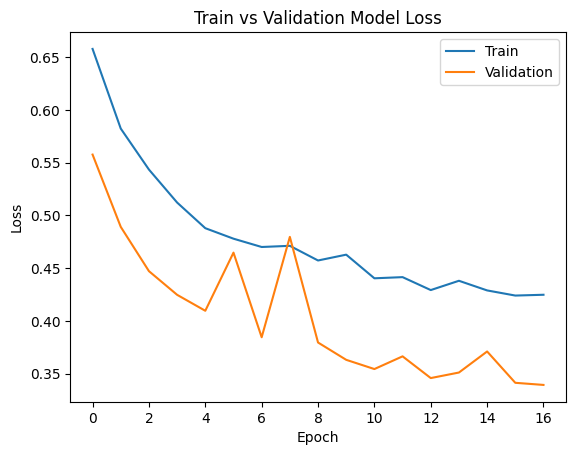

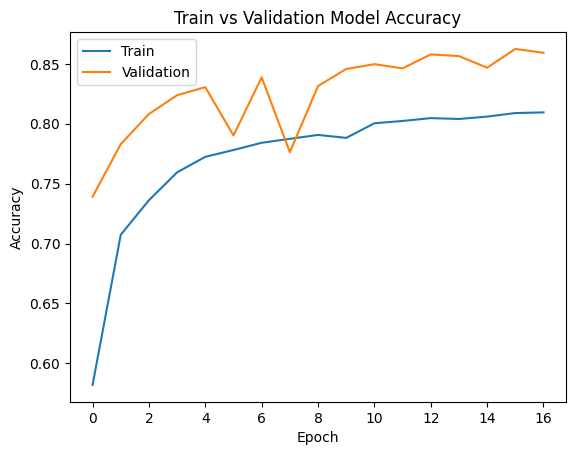


Calculating metrics...
Accuracy: 0.85584
Precision: [0.88678261 0.82948148]
Recall: [0.81584 0.89584]
F1 score: [0.84983333 0.86138462]
Support: [12500 12500]
              precision    recall  f1-score   support

         0.0       0.89      0.82      0.85     12500
         1.0       0.83      0.90      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



{'val_loss': 0.33934337316557417}

In [33]:
# ====== RNN_LSTM_FROZEN_EMBEDDINGS Function ======
#Best Hyperparameters: {'hidden_dim': 16, 'dropout': 0.6022217632336822, 'learning_rate': 0.0025565376011509387, 'num_layers': 4, 'num_epochs': 17, 'batch_size': 118, 'clip': 4.281124290951043}

RNN_LSTM(TEXT, train_data, valid_data, test_data, hidden_dim=16, num_layers=4, dropout=0.6, learning_rate=0.002, num_epochs=17, batch_size=118, clip=4)


CNN(
  (embedding): Embedding(25002, 100, padding_idx=1)
  (convs): ModuleList(
    (0): Conv2d(1, 20, kernel_size=(3, 100), stride=(1, 1))
    (1): Conv2d(1, 20, kernel_size=(4, 100), stride=(1, 1))
    (2): Conv2d(1, 20, kernel_size=(5, 100), stride=(1, 1))
  )
  (fc): Linear(in_features=60, out_features=1, bias=True)
  (dropout): Dropout(p=0.6, inplace=False)
)
The model has 2,524,321 trainable parameters


100%|██████████| 43/43 [00:00<00:00, 95.48it/s]


Epoch: 01 | Epoch Time: 0m 3s | Frozen: True
	Train Loss: 0.658 | Train Acc: 61.69%
	 Val. Loss: 0.569 |  Val. Acc: 75.95%


100%|██████████| 43/43 [00:00<00:00, 54.85it/s]


Epoch: 02 | Epoch Time: 0m 4s | Frozen: True
	Train Loss: 0.578 | Train Acc: 69.67%
	 Val. Loss: 0.510 |  Val. Acc: 79.36%


100%|██████████| 43/43 [00:00<00:00, 93.93it/s] 


Epoch: 03 | Epoch Time: 0m 3s | Frozen: True
	Train Loss: 0.561 | Train Acc: 71.34%
	 Val. Loss: 0.493 |  Val. Acc: 80.57%


100%|██████████| 43/43 [00:00<00:00, 149.60it/s]


Epoch: 04 | Epoch Time: 0m 1s | Frozen: True
	Train Loss: 0.551 | Train Acc: 72.79%
	 Val. Loss: 0.486 |  Val. Acc: 81.18%


100%|██████████| 43/43 [00:00<00:00, 148.99it/s]


Epoch: 05 | Epoch Time: 0m 1s | Frozen: True
	Train Loss: 0.540 | Train Acc: 73.19%
	 Val. Loss: 0.472 |  Val. Acc: 81.51%


100%|██████████| 43/43 [00:00<00:00, 136.74it/s]


Epoch: 06 | Epoch Time: 0m 2s | Frozen: True
	Train Loss: 0.534 | Train Acc: 73.61%
	 Val. Loss: 0.461 |  Val. Acc: 81.79%


100%|██████████| 43/43 [00:00<00:00, 63.72it/s] 


Epoch: 07 | Epoch Time: 0m 2s | Frozen: True
	Train Loss: 0.533 | Train Acc: 73.51%
	 Val. Loss: 0.470 |  Val. Acc: 81.93%


100%|██████████| 43/43 [00:00<00:00, 148.27it/s]


Epoch: 08 | Epoch Time: 0m 4s | Frozen: True
	Train Loss: 0.532 | Train Acc: 73.78%
	 Val. Loss: 0.470 |  Val. Acc: 81.34%


100%|██████████| 43/43 [00:00<00:00, 146.16it/s]


Epoch: 09 | Epoch Time: 0m 1s | Frozen: True
	Train Loss: 0.527 | Train Acc: 74.32%
	 Val. Loss: 0.464 |  Val. Acc: 81.16%


100%|██████████| 43/43 [00:00<00:00, 144.23it/s]


Epoch: 10 | Epoch Time: 0m 1s | Frozen: True
	Train Loss: 0.525 | Train Acc: 74.16%
	 Val. Loss: 0.473 |  Val. Acc: 81.06%


100%|██████████| 43/43 [00:00<00:00, 146.04it/s]


Epoch: 11 | Epoch Time: 0m 1s | Frozen: True
	Train Loss: 0.521 | Train Acc: 74.38%
	 Val. Loss: 0.459 |  Val. Acc: 81.79%


100%|██████████| 43/43 [00:00<00:00, 144.91it/s]


Epoch: 12 | Epoch Time: 0m 1s | Frozen: True
	Train Loss: 0.522 | Train Acc: 74.36%
	 Val. Loss: 0.470 |  Val. Acc: 80.19%


100%|██████████| 43/43 [00:00<00:00, 105.97it/s]


Epoch: 13 | Epoch Time: 0m 2s | Frozen: True
	Train Loss: 0.520 | Train Acc: 74.81%
	 Val. Loss: 0.454 |  Val. Acc: 81.60%


100%|██████████| 43/43 [00:00<00:00, 140.03it/s]


Epoch: 14 | Epoch Time: 0m 2s | Frozen: True
	Train Loss: 0.519 | Train Acc: 74.80%
	 Val. Loss: 0.452 |  Val. Acc: 81.49%


100%|██████████| 43/43 [00:00<00:00, 142.01it/s]


Epoch: 15 | Epoch Time: 0m 2s | Frozen: True
	Train Loss: 0.519 | Train Acc: 74.71%
	 Val. Loss: 0.463 |  Val. Acc: 81.06%


100%|██████████| 43/43 [00:00<00:00, 136.34it/s]


Epoch: 16 | Epoch Time: 0m 2s | Frozen: True
	Train Loss: 0.514 | Train Acc: 75.26%
	 Val. Loss: 0.458 |  Val. Acc: 81.30%


100%|██████████| 43/43 [00:00<00:00, 137.75it/s]


Epoch: 17 | Epoch Time: 0m 2s | Frozen: True
	Train Loss: 0.518 | Train Acc: 74.76%
	 Val. Loss: 0.460 |  Val. Acc: 80.95%


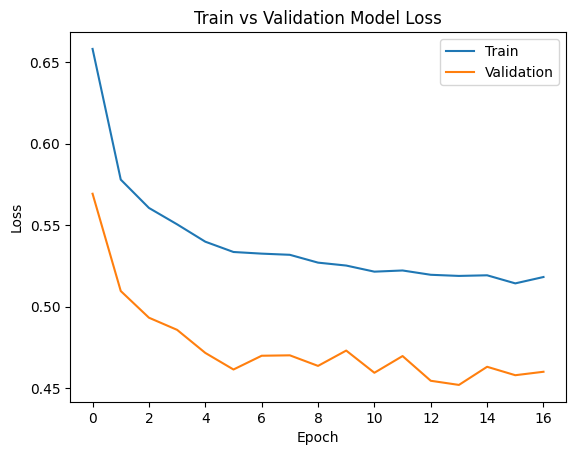

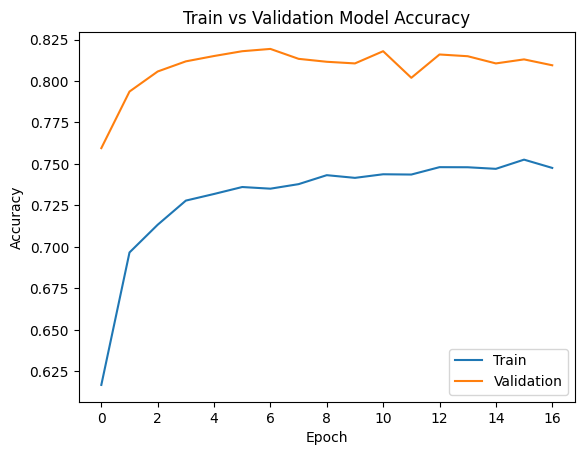


Calculating metrics...
Accuracy: 0.79928
Precision: [0.86476209 0.75373033]
Recall: [0.70952 0.88904]
F1 score: [0.77948673 0.81581266]
Support: [12500 12500]
              precision    recall  f1-score   support

         0.0       0.86      0.71      0.78     12500
         1.0       0.75      0.89      0.82     12500

    accuracy                           0.80     25000
   macro avg       0.81      0.80      0.80     25000
weighted avg       0.81      0.80      0.80     25000



{'val_loss': 0.4600273446981297}

In [ ]:
# ====== CNN_FROZEN_EMBEDDINGS Function ======
CNN_EMBEDDINGS(TEXT, train_data, valid_data, test_data,num_filters = 20,filter_sizes = [3,4,5],dropout=0.6, learning_rate=0.002, num_epochs=17, batch_size=118, clip=4)

**PART 6: TRAINING AND EVALUATION OF MODELS WITH GLOVE PRE-TRAINED EMBEDDINGS**

LSTM_Model(
  (embedding): Embedding(25002, 100, padding_idx=1)
  (lstm): LSTM(100, 16, num_layers=4, dropout=0.6, bidirectional=True)
  (dense): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.6, inplace=False)
)
The model has 2,534,537 trainable parameters



100%|██████████| 43/43 [00:00<00:00, 170.86it/s]


Epoch: 01 | Epoch Time: 0m 2s | Frozen: False
	Train Loss: 0.646 | Train Acc: 59.72%
	 Val. Loss: 0.476 |  Val. Acc: 79.39%


100%|██████████| 43/43 [00:00<00:00, 166.35it/s]


Epoch: 02 | Epoch Time: 0m 2s | Frozen: False
	Train Loss: 0.476 | Train Acc: 78.43%
	 Val. Loss: 0.385 |  Val. Acc: 83.83%


100%|██████████| 43/43 [00:00<00:00, 175.73it/s]


Epoch: 03 | Epoch Time: 0m 2s | Frozen: False
	Train Loss: 0.351 | Train Acc: 85.75%
	 Val. Loss: 0.305 |  Val. Acc: 87.67%


100%|██████████| 43/43 [00:00<00:00, 168.63it/s]


Epoch: 04 | Epoch Time: 0m 2s | Frozen: False
	Train Loss: 0.284 | Train Acc: 88.96%
	 Val. Loss: 0.326 |  Val. Acc: 85.89%


100%|██████████| 43/43 [00:00<00:00, 113.63it/s]


Epoch: 05 | Epoch Time: 0m 2s | Frozen: False
	Train Loss: 0.242 | Train Acc: 91.03%
	 Val. Loss: 0.327 |  Val. Acc: 88.34%


100%|██████████| 43/43 [00:00<00:00, 156.76it/s]


Epoch: 06 | Epoch Time: 0m 2s | Frozen: False
	Train Loss: 0.197 | Train Acc: 92.73%
	 Val. Loss: 0.330 |  Val. Acc: 88.05%


100%|██████████| 43/43 [00:00<00:00, 167.91it/s]


Epoch: 07 | Epoch Time: 0m 2s | Frozen: False
	Train Loss: 0.175 | Train Acc: 93.91%
	 Val. Loss: 0.327 |  Val. Acc: 88.50%


100%|██████████| 43/43 [00:00<00:00, 171.30it/s]


Epoch: 08 | Epoch Time: 0m 2s | Frozen: False
	Train Loss: 0.157 | Train Acc: 94.39%
	 Val. Loss: 0.364 |  Val. Acc: 87.08%


100%|██████████| 43/43 [00:00<00:00, 174.39it/s]


Epoch: 09 | Epoch Time: 0m 2s | Frozen: False
	Train Loss: 0.152 | Train Acc: 94.65%
	 Val. Loss: 0.418 |  Val. Acc: 86.42%


100%|██████████| 43/43 [00:00<00:00, 111.12it/s]


Epoch: 10 | Epoch Time: 0m 2s | Frozen: False
	Train Loss: 0.130 | Train Acc: 95.45%
	 Val. Loss: 0.392 |  Val. Acc: 87.99%


100%|██████████| 43/43 [00:00<00:00, 165.18it/s]


Epoch: 11 | Epoch Time: 0m 3s | Frozen: False
	Train Loss: 0.108 | Train Acc: 96.26%
	 Val. Loss: 0.394 |  Val. Acc: 87.63%


100%|██████████| 43/43 [00:00<00:00, 164.54it/s]


Epoch: 12 | Epoch Time: 0m 2s | Frozen: False
	Train Loss: 0.099 | Train Acc: 96.63%
	 Val. Loss: 0.434 |  Val. Acc: 87.49%


100%|██████████| 43/43 [00:00<00:00, 163.83it/s]


Epoch: 13 | Epoch Time: 0m 2s | Frozen: False
	Train Loss: 0.093 | Train Acc: 96.81%
	 Val. Loss: 0.444 |  Val. Acc: 87.21%


100%|██████████| 43/43 [00:00<00:00, 168.91it/s]


Epoch: 14 | Epoch Time: 0m 2s | Frozen: False
	Train Loss: 0.092 | Train Acc: 96.89%
	 Val. Loss: 0.446 |  Val. Acc: 87.54%


100%|██████████| 43/43 [00:00<00:00, 112.75it/s]


Epoch: 15 | Epoch Time: 0m 2s | Frozen: False
	Train Loss: 0.081 | Train Acc: 97.36%
	 Val. Loss: 0.459 |  Val. Acc: 87.00%


100%|██████████| 43/43 [00:00<00:00, 172.74it/s]


Epoch: 16 | Epoch Time: 0m 2s | Frozen: False
	Train Loss: 0.072 | Train Acc: 97.67%
	 Val. Loss: 0.551 |  Val. Acc: 87.06%


100%|██████████| 43/43 [00:00<00:00, 174.79it/s]


Epoch: 17 | Epoch Time: 0m 2s | Frozen: False
	Train Loss: 0.072 | Train Acc: 97.71%
	 Val. Loss: 0.486 |  Val. Acc: 86.90%


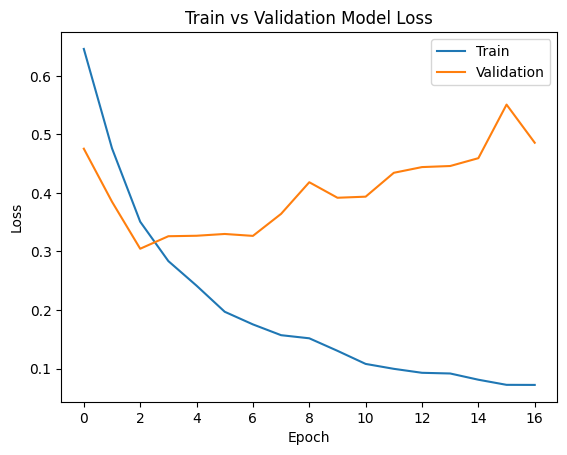

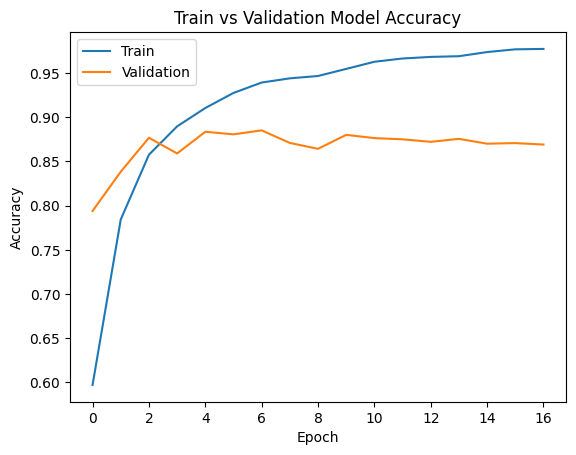


Calculating metrics...
Accuracy: 0.84252
Precision: [0.87194857 0.81740678]
Recall: [0.80296 0.88208]
F1 score: [0.83603348 0.84851283]
Support: [12500 12500]
              precision    recall  f1-score   support

         0.0       0.87      0.80      0.84     12500
         1.0       0.82      0.88      0.85     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000



{'val_loss': 0.48574831111486566}

In [ ]:
# === Run the function ===
RNN_LSTM(TEXT, train_data, valid_data, test_data, hidden_dim=16, num_layers=4, dropout=0.6, learning_rate=0.002, num_epochs=17, batch_size=118, clip=4, freeze_embeddings=False)


CNN(
  (embedding): Embedding(25002, 100, padding_idx=1)
  (convs): ModuleList(
    (0): Conv2d(1, 20, kernel_size=(3, 100), stride=(1, 1))
    (1): Conv2d(1, 20, kernel_size=(4, 100), stride=(1, 1))
    (2): Conv2d(1, 20, kernel_size=(5, 100), stride=(1, 1))
  )
  (fc): Linear(in_features=60, out_features=1, bias=True)
  (dropout): Dropout(p=0.6, inplace=False)
)
The model has 2,524,321 trainable parameters


100%|██████████| 43/43 [00:00<00:00, 94.86it/s] 


Epoch: 01 | Epoch Time: 0m 10s | Frozen: False
	Train Loss: 0.634 | Train Acc: 64.20%
	 Val. Loss: 0.483 |  Val. Acc: 79.85%


100%|██████████| 43/43 [00:00<00:00, 108.97it/s]


Epoch: 02 | Epoch Time: 0m 8s | Frozen: False
	Train Loss: 0.473 | Train Acc: 78.06%
	 Val. Loss: 0.406 |  Val. Acc: 83.67%


100%|██████████| 43/43 [00:00<00:00, 160.76it/s]


Epoch: 03 | Epoch Time: 0m 8s | Frozen: False
	Train Loss: 0.420 | Train Acc: 81.73%
	 Val. Loss: 0.379 |  Val. Acc: 84.82%


100%|██████████| 43/43 [00:00<00:00, 86.64it/s]


Epoch: 04 | Epoch Time: 0m 8s | Frozen: False
	Train Loss: 0.389 | Train Acc: 83.70%
	 Val. Loss: 0.361 |  Val. Acc: 85.66%


100%|██████████| 43/43 [00:00<00:00, 50.00it/s]


Epoch: 05 | Epoch Time: 0m 10s | Frozen: False
	Train Loss: 0.353 | Train Acc: 85.54%
	 Val. Loss: 0.344 |  Val. Acc: 85.71%


100%|██████████| 43/43 [00:00<00:00, 158.71it/s]


Epoch: 06 | Epoch Time: 0m 8s | Frozen: False
	Train Loss: 0.331 | Train Acc: 86.50%
	 Val. Loss: 0.341 |  Val. Acc: 86.04%


100%|██████████| 43/43 [00:00<00:00, 161.93it/s]


Epoch: 07 | Epoch Time: 0m 8s | Frozen: False
	Train Loss: 0.313 | Train Acc: 87.48%
	 Val. Loss: 0.343 |  Val. Acc: 85.87%


100%|██████████| 43/43 [00:00<00:00, 104.39it/s]


Epoch: 08 | Epoch Time: 0m 8s | Frozen: False
	Train Loss: 0.296 | Train Acc: 88.17%
	 Val. Loss: 0.345 |  Val. Acc: 85.45%


100%|██████████| 43/43 [00:00<00:00, 159.49it/s]


Epoch: 09 | Epoch Time: 0m 8s | Frozen: False
	Train Loss: 0.276 | Train Acc: 89.66%
	 Val. Loss: 0.346 |  Val. Acc: 85.38%


100%|██████████| 43/43 [00:00<00:00, 161.93it/s]


Epoch: 10 | Epoch Time: 0m 8s | Frozen: False
	Train Loss: 0.257 | Train Acc: 89.89%
	 Val. Loss: 0.349 |  Val. Acc: 85.74%


100%|██████████| 43/43 [00:00<00:00, 112.40it/s]


Epoch: 11 | Epoch Time: 0m 8s | Frozen: False
	Train Loss: 0.242 | Train Acc: 90.67%
	 Val. Loss: 0.356 |  Val. Acc: 85.23%


100%|██████████| 43/43 [00:00<00:00, 156.52it/s]


Epoch: 12 | Epoch Time: 0m 8s | Frozen: False
	Train Loss: 0.222 | Train Acc: 91.62%
	 Val. Loss: 0.366 |  Val. Acc: 85.01%


100%|██████████| 43/43 [00:00<00:00, 154.33it/s]


Epoch: 13 | Epoch Time: 0m 8s | Frozen: False
	Train Loss: 0.215 | Train Acc: 92.21%
	 Val. Loss: 0.373 |  Val. Acc: 84.21%


100%|██████████| 43/43 [00:00<00:00, 162.44it/s]


Epoch: 14 | Epoch Time: 0m 8s | Frozen: False
	Train Loss: 0.203 | Train Acc: 92.60%
	 Val. Loss: 0.377 |  Val. Acc: 84.73%


100%|██████████| 43/43 [00:00<00:00, 160.44it/s]


Epoch: 15 | Epoch Time: 0m 8s | Frozen: False
	Train Loss: 0.186 | Train Acc: 93.24%
	 Val. Loss: 0.399 |  Val. Acc: 84.26%


100%|██████████| 43/43 [00:00<00:00, 104.95it/s]


Epoch: 16 | Epoch Time: 0m 8s | Frozen: False
	Train Loss: 0.186 | Train Acc: 93.14%
	 Val. Loss: 0.393 |  Val. Acc: 84.01%


100%|██████████| 43/43 [00:00<00:00, 159.53it/s]


Epoch: 17 | Epoch Time: 0m 8s | Frozen: False
	Train Loss: 0.176 | Train Acc: 93.59%
	 Val. Loss: 0.393 |  Val. Acc: 84.26%


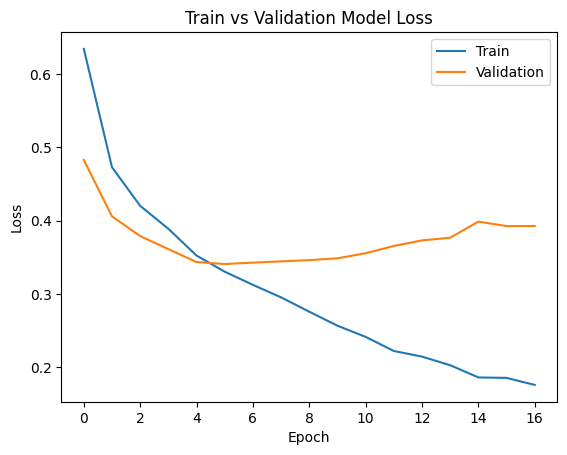

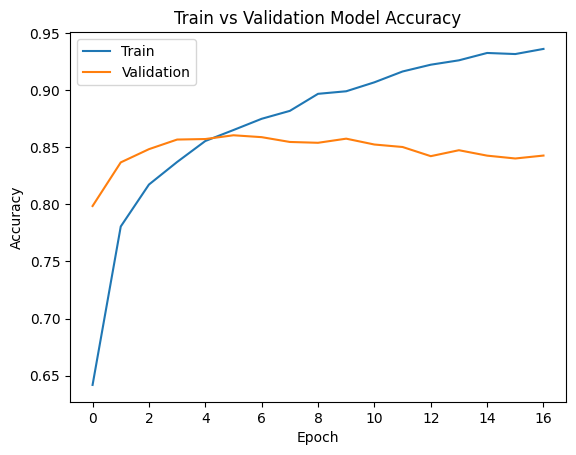


Calculating metrics...
Accuracy: 0.8252
Precision: [0.83357952 0.81723115]
Recall: [0.81264 0.83776]
F1 score: [0.82297659 0.82736825]
Support: [12500 12500]
              precision    recall  f1-score   support

         0.0       0.83      0.81      0.82     12500
         1.0       0.82      0.84      0.83     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000



{'val_loss': 0.3928542864877124}

In [ ]:
# === Run the function ===
CNN_EMBEDDINGS(TEXT, train_data, valid_data, test_data,num_filters = 20,filter_sizes = [3,4,5],dropout=0.6, learning_rate=0.002, num_epochs=17, batch_size=118, clip=4,freeze_embeddings=False)

**PART 7: USE A PRE-TRAINED MODEL FROM HUGGING FACE AND FINE TUNE IT TO THE IMDB DATASET**

In [ ]:
# Define the pre-trained model from Hugging Face and its tokenizer
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels = 2)
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [ ]:
# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])


# Define Trainer parameters
def compute_metrics(p):

  pred, labels = p
  pred = np.argmax(pred, axis=1)

  accuracy = accuracy_score(y_true=labels, y_pred=pred)
  recall = recall_score(y_true=labels, y_pred=pred)
  precision = precision_score(y_true=labels, y_pred=pred)
  f1 = f1_score(y_true=labels, y_pred=pred)
  return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}

In [ ]:
# Get the texts from the training, validation and test data
X_train = list(train_dataframe['review'])
X_val = list(valid_dataframe['review'])
X_test = list(test_dataframe['review'])

y_train = list(train_dataframe['label'])
y_val = list(valid_dataframe['label'])

# Tokenize and pad the data using DistilBert's tokenizer
X_train_tokenized = tokenizer(X_train, padding = True, truncation = True)
X_val_tokenized = tokenizer(X_val, padding = True, truncation = True)
X_test_tokenized = tokenizer(X_test, padding = True, truncation = True)

# Create the Datasets
train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)
test_dataset = Dataset(X_test_tokenized)
print('Training, validation and testing datasets are ready!')

Training, validation and testing datasets are ready!


In [ ]:
# ------ Train the model ------
# Define the Trainer
args = TrainingArguments(
    output_dir = 'output',
    evaluation_strategy = 'steps',
    eval_steps = 500,
    per_device_train_batch_size = 10,
    per_device_eval_batch_size = 8,
    num_train_epochs = 3,
    seed = 42,
    learning_rate = 2e-5,
    weight_decay = 0.01,
    load_best_model_at_end = True)

trainer = Trainer(
    model = model,
    args = args,
    train_dataset = train_dataset,
    eval_dataset = val_dataset,
    compute_metrics = compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience = 3)])

# Train the pre-trained model
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
500,0.420900,0.307679,0.878200,0.860439,0.904573,0.881954
1000,0.324300,0.338971,0.884200,0.874903,0.898211,0.886404


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
500,0.420900,0.307679,0.878200,0.860439,0.904573,0.881954
1000,0.324300,0.338971,0.884200,0.874903,0.898211,0.886404
1500,0.324200,0.287436,0.880200,0.937443,0.816302,0.872689
2000,0.325200,0.264963,0.894600,0.899839,0.889463,0.894621
2500,0.224200,0.310160,0.899200,0.913616,0.883101,0.898099
3000,0.232400,0.330476,0.898200,0.901843,0.895030,0.898423
3500,0.231700,0.302466,0.902800,0.901147,0.906163,0.903648


TrainOutput(global_step=3500, training_loss=0.29755510820661274, metrics={'train_runtime': 2545.5598, 'train_samples_per_second': 23.57, 'train_steps_per_second': 2.357, 'total_flos': 4636358952960000.0, 'train_loss': 0.29755510820661274, 'epoch': 1.75})

In [ ]:
# ------ Make predictions ------

# Load the trained model
model_path = 'output/checkpoint-2000'
model = DistilBertForSequenceClassification.from_pretrained(model_path, num_labels = 2)

# Define the test trainer
test_trainer = Trainer(model)

# Make prediction
raw_pred, _, _ = test_trainer.predict(test_dataset)

# Preprocess raw predictions
y_pred = np.argmax(raw_pred, axis=1)

In [ ]:
print(y_pred)

[1 0 1 ... 0 1 0]


**PART 8: PRESENTING THE RESULTS/ COMMENT ON THE FINDINGS**

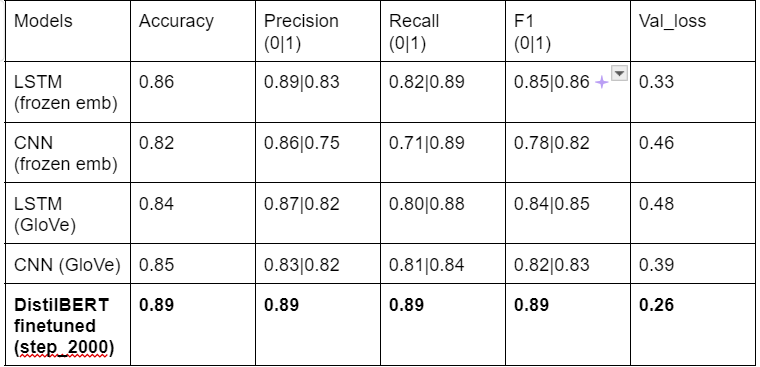

DistilBert: These are the results from the best loaded model at 2000 evaluation steps.
From the results’ board above, it is evident that the DistilBert model achieved the highest scores of all the models. It also seems that the CNN with the frozen embeddings did not achieve as satisfying results as the other models. Second best model after DistillBERT seems to be the LSTM with the frozen embeddings, since it achieved second best scoring performance in all metrics.
From the plotted learning curves above, we can see though that:
the CNN model with the frozen embedings seems to be underfitting the train data, since it reports consistently higher accuracy and lower loss in the validation compared to the train data and the two model trained with GloVe also show some overfitting on the train data.

This implies that the chosen hyperarameters from Optuna, did not help the models in optimization.
1. Undefitting: First it seems that freezing the embeddings with the CNN architecture and the given optimized hyperprameters were not enough for the complexity of our text data. A more complex model is needed.

2. Overfitting: It seems that retraining the pretrained GloVe embeddings and using the chosen Optuna hyperparameters confused the model.
Trying out other learning rates, dropout rates, or smaller layer sizes might be necessary to improve model generalization and performance.


**References**

Maas, A. L., Daly, R. E., Pham, P. T., Huang, D., Ng, A. Y., & Potts, C. (2011, June 1). Learning Word Vectors for Sentiment Analysis. ACLWeb; Association for Computational Linguistics. http://www.aclweb.org/anthology/P11-1015